In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from scipy.io import wavfile

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torchaudio.datasets import SPEECHCOMMANDS
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Load the speech command dataset from pytorch dataset
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("/Users/invincibleo/Leo/Projects/Datasets/", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [3]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
valid_set = SubsetSC("validation")
test_set = SubsetSC("testing")

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


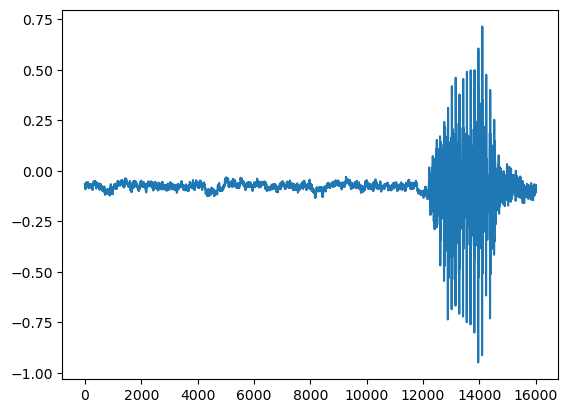

In [26]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [5]:
# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five',
          'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left',
          'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila',
          'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [6]:
print("Number of labels:", len(labels))
print("Labels:", labels)
print("Number of training examples:", len(train_set))
print("Number of validation examples:", len(valid_set))
print("Number of testing examples:", len(test_set))

Number of labels: 35
Labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Number of training examples: 84843
Number of validation examples: 9981
Number of testing examples: 11005


In [7]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

In [8]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [10]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [12]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def validation(model, epoch):
    model.eval()
    correct = 0
    for data, target in valid_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(valid_loader.dataset)} ({100. * correct / len(valid_loader.dataset):.0f}%)\n")

In [16]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        validation(model, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/2 [00:00<11:46, 353.85s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 1.007882


  3%|▎         | 0.05599999999999999/2 [00:16<09:00, 278.17s/it]  

Train Epoch: 1 [5120/84843 (6%)]	Loss: 1.254683


  5%|▌         | 0.10933333333333328/2 [00:31<09:05, 288.76s/it] 

Train Epoch: 1 [10240/84843 (12%)]	Loss: 1.051331


  8%|▊         | 0.16266666666666676/2 [00:46<08:19, 272.00s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 1.304653


 11%|█         | 0.21600000000000033/2 [01:01<08:20, 280.68s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.864067


 13%|█▎        | 0.2693333333333337/2 [01:16<07:43, 268.09s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.974392


 16%|█▌        | 0.3226666666666667/2 [01:30<07:34, 271.03s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.025163


 19%|█▉        | 0.3759999999999997/2 [01:45<07:15, 267.96s/it] 

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.144968


 21%|██▏       | 0.42933333333333273/2 [01:59<07:02, 269.19s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.095779


 24%|██▍       | 0.48266666666666574/2 [02:14<06:46, 267.82s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.992831


 27%|██▋       | 0.5359999999999995/2 [02:28<06:31, 267.28s/it] 

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.781285


 29%|██▉       | 0.5893333333333336/2 [02:42<06:16, 267.18s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.906582


 32%|███▏      | 0.6426666666666677/2 [02:57<06:09, 272.04s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.953687


 35%|███▍      | 0.6960000000000018/2 [03:11<05:52, 270.22s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.066092


 37%|███▋      | 0.749333333333336/2 [03:26<05:42, 274.15s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.846763


 40%|████      | 0.8026666666666701/2 [03:40<05:22, 269.24s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.978737


 43%|████▎     | 0.8560000000000042/2 [03:55<05:13, 273.94s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.849006


 49%|████▉     | 0.9893333333333395/2 [04:30<04:23, 260.81s/it]


Test Epoch: 1	Accuracy: 6949/9981 (70%)



 50%|████▉     | 0.9920000000000062/2 [04:30<04:24, 262.80s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.870890


 52%|█████▏    | 1.0453333333333383/2 [04:45<04:20, 273.00s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.047267


 55%|█████▍    | 1.0986666666666702/2 [04:59<04:15, 282.94s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.767465


 58%|█████▊    | 1.1520000000000021/2 [05:14<03:48, 269.47s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.796828


 60%|██████    | 1.205333333333334/2 [05:28<03:32, 267.81s/it] 

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.871721


 63%|██████▎   | 1.258666666666666/2 [05:43<03:30, 283.39s/it] 

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.725587


 66%|██████▌   | 1.3119999999999978/2 [05:59<03:21, 293.37s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.832971


 68%|██████▊   | 1.3653333333333297/2 [06:14<03:01, 286.06s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.845465


 71%|███████   | 1.4186666666666616/2 [06:30<02:41, 277.71s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.874336


 74%|███████▎  | 1.4719999999999935/2 [06:44<02:21, 267.71s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.694098


 76%|███████▋  | 1.5253333333333254/2 [06:59<02:07, 268.40s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.829562


 79%|███████▉  | 1.5786666666666573/2 [07:13<01:55, 273.51s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.764859


 82%|████████▏ | 1.6319999999999892/2 [07:28<01:40, 271.92s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.837409


 84%|████████▍ | 1.6853333333333211/2 [07:42<01:25, 270.44s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.777821


 87%|████████▋ | 1.738666666666653/2 [07:57<01:10, 271.28s/it] 

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.894555


 90%|████████▉ | 1.791999999999985/2 [08:12<00:57, 277.61s/it] 

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.603085


 92%|█████████▏| 1.8453333333333168/2 [08:26<00:42, 272.18s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.857631


 99%|█████████▉| 1.9786666666666466/2 [09:01<00:05, 273.61s/it]


Test Epoch: 2	Accuracy: 7205/9981 (72%)



In [17]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
    else:
        print("All examples in this dataset were correctly classified!")
        print("In this case, let's just look at the last data point")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

All examples in this dataset were correctly classified!
In this case, let's just look at the last data point
Data point #0. Expected: right. Predicted: right.
Data point #1. Expected: right. Predicted: two.


In [29]:
def record(seconds=5, sample_rate=16000):

    import sounddevice as sd
    from io import BytesIO

    # Make a 1s recording
    print("Start recording.")
    recording = sd.rec(int(seconds * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    
    # Define the file format
    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    # Write the recording to a file using scipy wavfile
    wavfile.write(filename, sample_rate, recording)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
record_wav, sample_rate = record()
# sample_rate, record_wav = wavfile.read("_audio.wav")
# Check if record_wav is a torch tensor
if not isinstance(record_wav, torch.Tensor):
    record_wav = torch.tensor(record_wav, dtype=torch.float32)
record_wav = torch.reshape(record_wav, (1, -1))
print(f"Predicted: {predict(record_wav)}.")
ipd.Audio(record_wav, rate=sample_rate)

Start recording.


/var/folders/r7/nqj9d9fj6hv8drl41_qwc6wr0000gn/T/ipykernel_8790/2797688603.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  record_wav = torch.tensor(record_wav, dtype=torch.float32)


RuntimeError: shape '[1, 1]' is invalid for input of size 80000